In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import os

In [11]:
def processPBSim(basePath, baseFolder, baseName, pltInputPower, extDataList, xL=-100.0, xR=-100.0, wind=-100):
    listOfFiles = os.listdir(basePath + "/" + baseFolder)
    timestep = listOfFiles[-2].split(".")
    timestep = timestep[0].split("restart")
    timestep = timestep[1]

    filename = basePath + "/" + baseFolder + "/" + baseName + "restart" + timestep + ".h5"
    hdfFile = h5py.File(filename, 'r')

    dissFile = basePath + "/" + baseFolder + "/" + baseName + "stats/diss.txt"
    tkeFile = basePath + "/" + baseFolder + "/" + baseName + "stats/tke.txt" 
    varFile = basePath + "/" + baseFolder + "/" + baseName + "stats/var.txt" 
    intScFile = basePath + "/" + baseFolder + "/" + baseName + "stats/intsc_ii.txt" 
    
    # Read parameters from HDF file
    visc = hdfFile['nu'][0]
    forceAmp = hdfFile['forceC1'][0]
    forceStd = hdfFile['forceC2'][0]
    forceMean = hdfFile['forceKf'][0]
    Lx = hdfFile["Lx"][0]
    Ly = hdfFile["Ly"][0]
    nx = hdfFile["nx"][0]
    ny = hdfFile["ny"][0]
    grav = hdfFile["grav"][0]
    gradV = hdfFile["gradv"][0]
    bruVai = np.sqrt(-gradV*grav)
    
    print ("viscosity is ", visc)

    #extData = pd.DataFrame(extDataList, columns=['times','ke','keDiss','pe','peDiss'])
    #extData['diss'] = extData['keDiss'] + extData['peDiss']
    #extData['ene'] = extData['ke'] + extData['pe']
    
    # Integrating forcing power input to determine target diss
    x = np.linspace(0, 7, 1000)
    y = forceAmp * np.exp(-((x-forceMean)/forceStd)**2)
    eps = np.trapz(y,x)

    # Plot Power Input Spectrum
    if (pltInputPower):
        plt.plot(x,y)
        plt.show()

    # Plot dissipation time series    
    dissData = pd.read_csv(dissFile, skiprows=False, header=None, delim_whitespace=True, 
                           names=['step','time','keDiss','peDiss'])
    dissData['totalDiss'] = dissData['keDiss'] + dissData['peDiss']
    dissData['targetDiss'] = eps

    if (wind > -100):
        print ("Moving average of ", wind, " pts out of ", len(dissData['keDiss']))
        dissData['rollAvg'] = dissData.iloc[:,4].rolling(window=wind).mean()
        #extData['rollAvg'] = extData.iloc[:,5].rolling(window=wind).mean()

    #print (dissData)
    
    # Determine component dissipation
    epsk = dissData['keDiss'].mean()
    epsp = dissData['peDiss'].mean()  
        
    plt.plot(dissData['time'],dissData['totalDiss'])
    #plt.plot(dissData['time'],dissData['keDiss'])
    #plt.plot(dissData['time'],dissData['peDiss'])
    #plt.plot(extData['times'], extData['diss'])
    plt.plot(dissData['time'],dissData['targetDiss'],'k')
    plt.plot(dissData['time'][wind+1:],dissData['rollAvg'][wind+1:],'r',linewidth=2.0)
    #plt.plot(extData['times'][wind+1:],extData['rollAvg'][wind+1:],'y',linewidth=2.0)

    plt.ylim(eps*3.0/5.0,eps*5.0/3.0)
    if ((xL > -100.0) or (xR > -100.0)):
        plt.xlim(xL, xR)
    plt.title("Dissipation Time Series")

    plt.show()
    
    
    # Plot energy time series
    tkeData = pd.read_csv(tkeFile, skiprows=False, header=None, delim_whitespace=True, 
                           names=['step','time','ke','pe'])
    tkeData['tke'] = tkeData['ke'] + tkeData['pe']

    if (wind > -100):
        tkeData['rollAvg'] = tkeData.iloc[:,4].rolling(window=wind).mean()

    #print (tkeData)
    
    plt.plot(tkeData['time'],tkeData['tke'])
    plt.plot(tkeData['time'],tkeData['ke'])
    plt.plot(tkeData['time'],tkeData['pe'])
    plt.plot(tkeData['time'][wind+1:],tkeData['rollAvg'][wind+1:],'r',linewidth=2.0)
    #plt.plot(extDataList[:,0], extDataList[:,1] + extDataList[:,3])
    plt.ylim(0,np.max(tkeData['tke'])*1.1)
    plt.title("Energy Time Series")

    plt.show()
    
    # Plot variance time series
    varData = pd.read_csv(varFile, skiprows=False, header=None, delim_whitespace=True, 
                           names=['step','time','uu','vv','ww','rr'])
    varData['hvar'] = (varData['uu'] + varData['ww'])/2.0

    plt.plot(varData['time'],varData['uu'])
    plt.plot(varData['time'],varData['vv'])
    plt.plot(varData['time'],varData['ww'])
    plt.ylim(0,np.max(varData['uu'])*1.05)
    plt.title("Velocity Variance Time Series")
    plt.show()
    
    plt.plot(varData['time'],varData['rr'])
    plt.ylim(0,np.max(varData['rr'])*1.05)
    plt.title("Density variance Time Series")
    plt.show()
    
    # Determine horizontal rms
    hrms = np.sqrt(varData['hvar'].mean())
    
    # Plot length scales time series
    intScData = pd.read_csv(intScFile, skiprows=False, header=None, delim_whitespace=True, 
                           names=['step','time','Lu','Lv','Lw','Lr'])
    
    # Need to divide by 2 to correct value from Poongback   FIXME: VERIFY
    intScData['Lu'] = intScData['Lu']/2.0
    intScData['Lv'] = intScData['Lv']/2.0
    intScData['Lw'] = intScData['Lw']/2.0
    intScData['Lr'] = intScData['Lr']/2.0
    
    intScData['Lhor'] = (intScData['Lu'] + intScData['Lw'])/2.0

    plt.plot(intScData['time'],intScData['Lu'])
    plt.plot(intScData['time'],intScData['Lv'])
    plt.plot(intScData['time'],intScData['Lw'])
    plt.ylim(0,np.max(intScData['Lu'])*1.05)
    plt.title("Integral Length Scales Time Series")
    plt.show()
    
    # Determine horizontal length scale
    horizL = np.sqrt(intScData['Lhor'].mean())
    
    print ("Dissipation is ", epsk + epsp)
    print ("Reynolds number is ", hrms**4 / (visc * epsk), "or ", hrms*horizL/visc)
    print ("Froude number is ", epsk / (hrms**2 * bruVai), "or ", hrms/(horizL*bruVai))
    print ("The Gibson number is ", epsk /(visc * bruVai**2), "or ", hrms*hrms*hrms/(visc*horizL*bruVai**2))

viscosity is  0.041


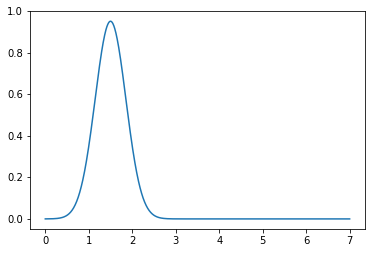

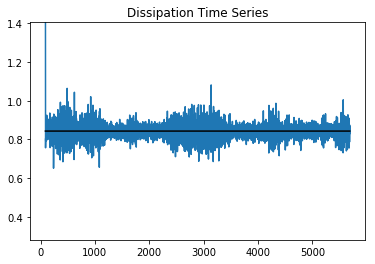

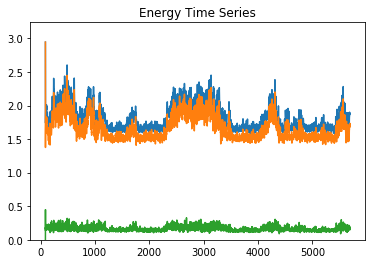

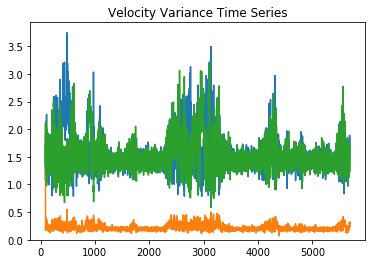

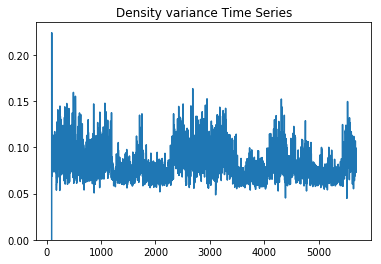

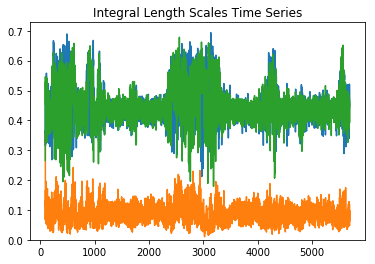

Dissipation is  0.841481057553488
Reynolds number is  87.0613808357883 or  20.476948442075393
Froude number is  0.21805193549378363 or  0.9270865066494729
The Gibson number is  4.139476704720467 or  17.599719942158348


In [29]:
bPath = '/Users/jmelvin/Desktop/WorkFromHome/stratDNS'
bName = 'N2-3232-Eps084'
pltPowerInput = True
processPBSim(bPath, bName, bName, pltPowerInput)

viscosity is  0.0085


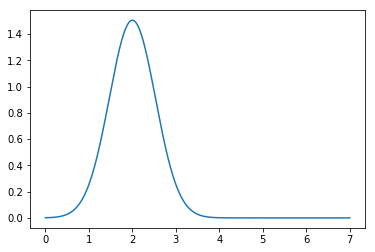

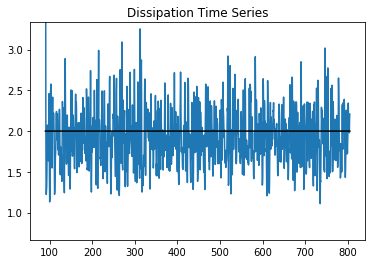

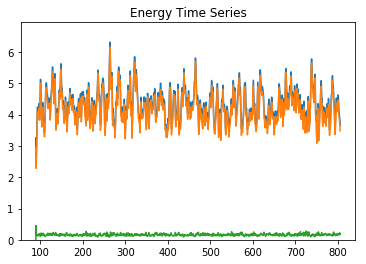

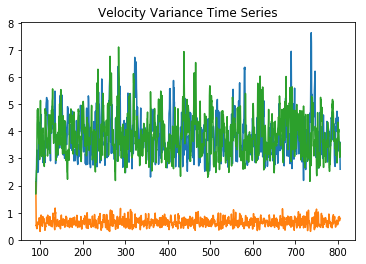

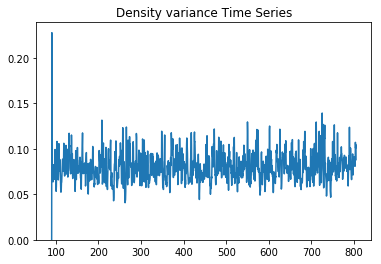

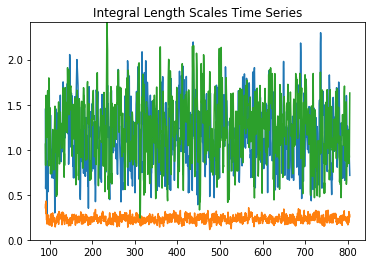

Dissipation is  1.9210815693470724
Reynolds number is  1078.1117118480825 or  253.6729483196166
Froude number is  0.21048476945588934 or  0.8945616654012358
The Gibson number is  47.76448681402445 or  202.9993855700021


In [30]:
bPath = '/Users/jmelvin/Desktop/WorkFromHome/stratDNS'
bName = 'N2-12832-Eps200'
pltPowerInput = True
processPBSim(bPath, bName, bName, pltPowerInput)

viscosity is  0.0065


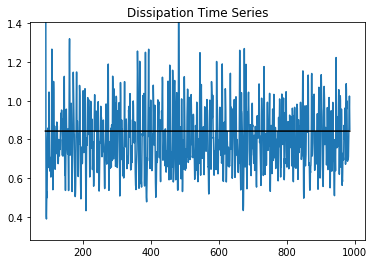

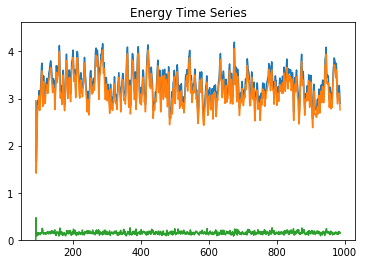

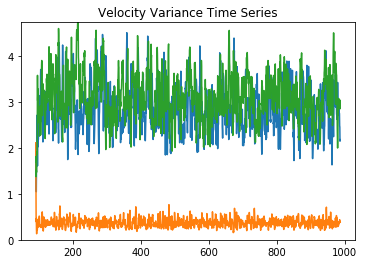

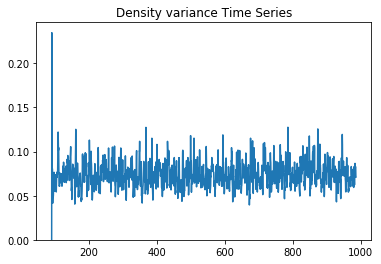

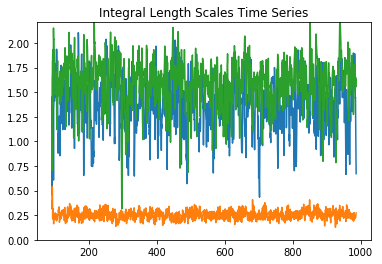

Dissipation is  0.8076310308804229
Reynolds number is  2197.8566264471715 or  324.99430208584005
Froude number is  0.10428745368950643 or  0.7052704298989333
The Gibson number is  23.903609534944305 or  161.6542390903417


In [31]:
bPath = '/Users/jmelvin/Desktop/WorkFromHome/stratDNS'
bName = 'N2-12832-Eps084'
pltPowerInput = False
processPBSim(bPath, bName, bName, pltPowerInput)

viscosity is  0.0085


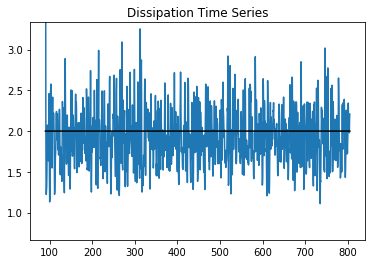

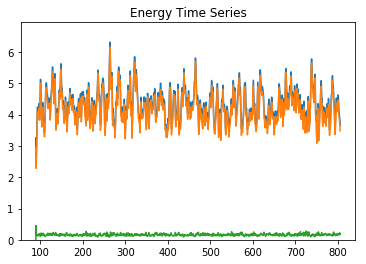

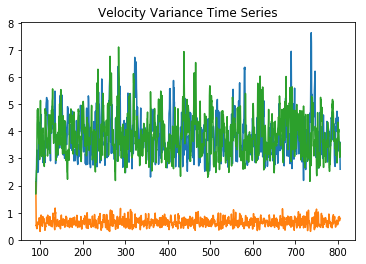

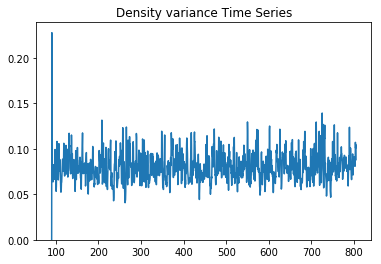

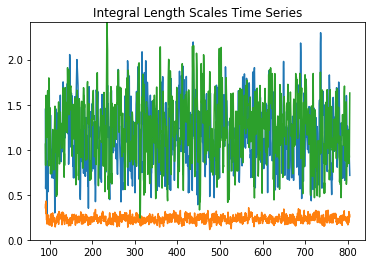

Dissipation is  1.9210815693470724
Reynolds number is  1078.1117118480825 or  253.6729483196166
Froude number is  0.21048476945588934 or  0.8945616654012358
The Gibson number is  47.76448681402445 or  202.9993855700021


In [32]:
bPath = '/Users/jmelvin/Desktop/WorkFromHome/stratDNS'
bName = 'N2-12832-Eps200'
pltPowerInput = False
processPBSim(bPath, bName, bName, pltPowerInput)

viscosity is  0.00238


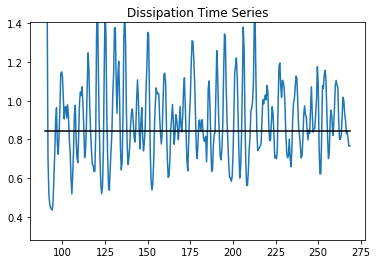

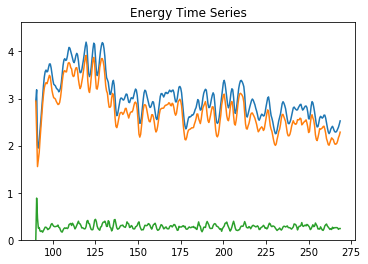

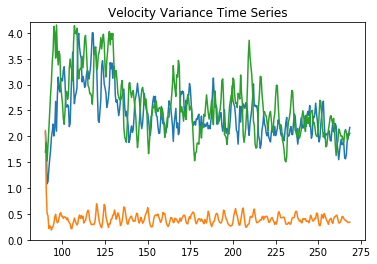

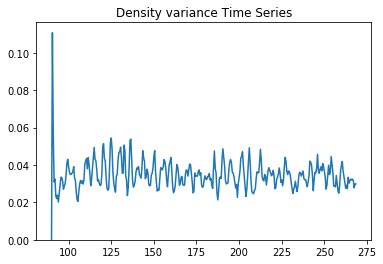

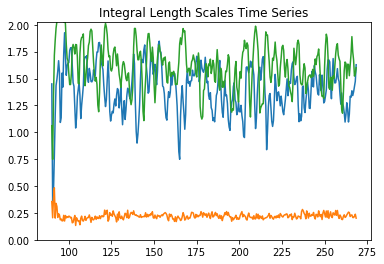

Dissipation is  0.9177887044282694
Reynolds number is  4427.081760805879 or  820.6340238755098
Froude number is  0.059969962068074346 or  0.3235204945731905
The Gibson number is  15.921540687689536 or  85.8920789678247


In [33]:
bPath = '/Users/jmelvin/Desktop/WorkFromHome/stratDNS'
bName = 'F025_25664'
pltPowerInput = False
processPBSim(bPath, bName, bName, pltPowerInput)

viscosity is  0.00251215


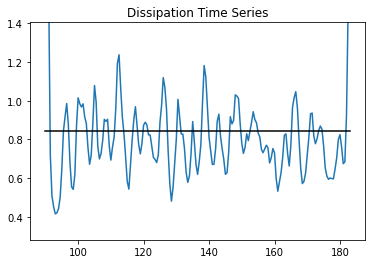

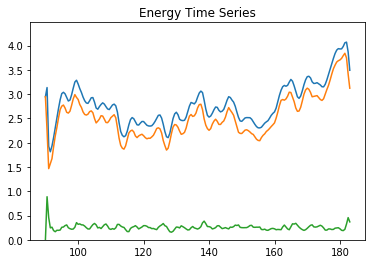

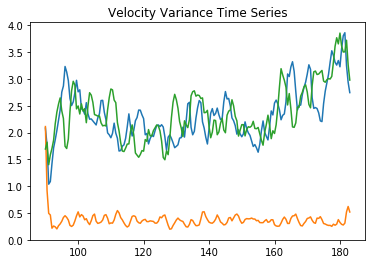

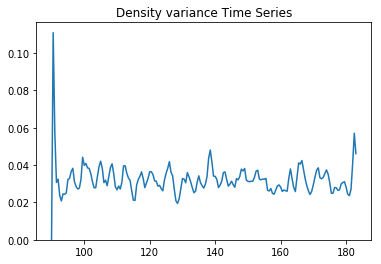

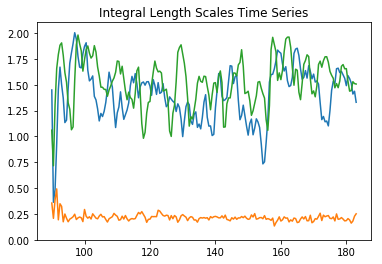

Dissipation is  0.836425373487488
Reynolds number is  3945.5940501345594 or  739.4820666163812
Froude number is  0.059258877885432056 or  0.3161827535213302
The Gibson number is  13.855405704639509 or  73.92715628732876


In [34]:
bPath = '/Users/jmelvin/Desktop/WorkFromHome/stratDNS'
bName = 'N4-25664-Eps084'
pltPowerInput = False
processPBSim(bPath, bName, bName, pltPowerInput)

viscosity is  0.0033545


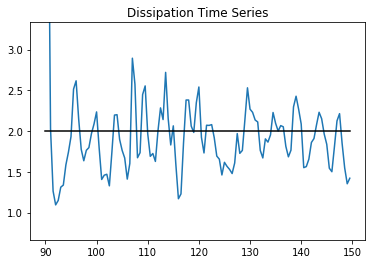

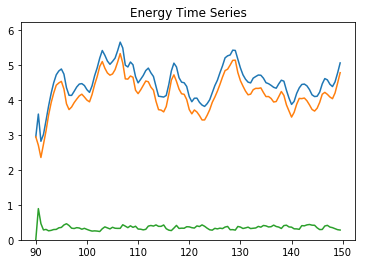

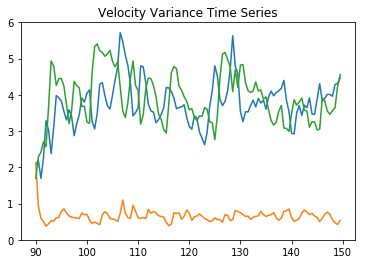

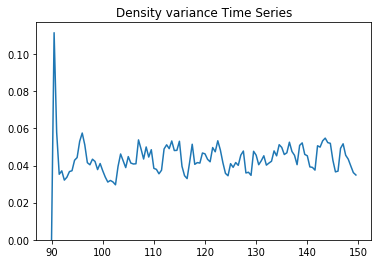

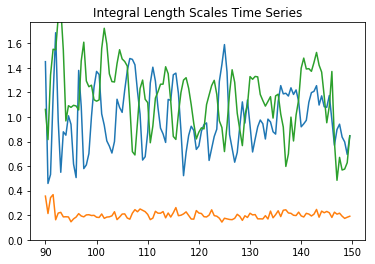

Dissipation is  1.9385393809851974
Reynolds number is  3201.9238364100925 or  605.1582423704627
Froude number is  0.089282893880964 or  0.4724004501389979
The Gibson number is  25.52392818439289 or  135.0484358145725


In [35]:
bPath = '/Users/jmelvin/Desktop/WorkFromHome/stratDNS'
bName = 'N4-25664-Eps200'
pltPowerInput = False
processPBSim(bPath, bName, bName, pltPowerInput)

viscosity is  0.00099695


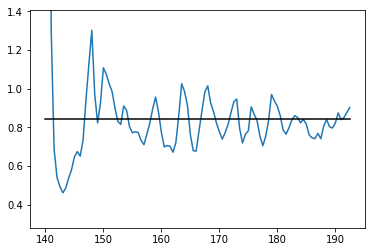

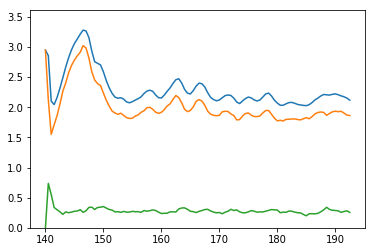

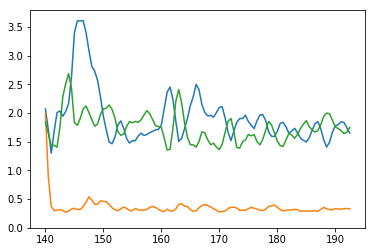

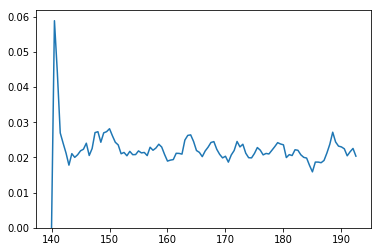

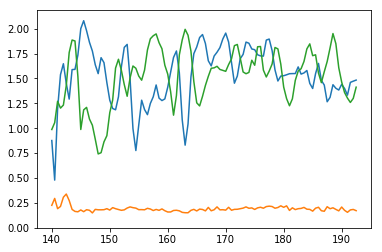

Reynolds number is  5445.566447739054 or  1679.3176202197856
Froude number is  0.06778011383030332 or  0.2197923187692906
The Gibson number is  25.017715501358 or  81.12558964006234


In [111]:
bPath = '/Users/jmelvin/Desktop/WorkFromHome/stratDNS'
bName = 'N5-512128-Eps084'
pltPowerInput = False
processPBSim(bPath, bName, bName, pltPowerInput)

viscosity is  0.00099695


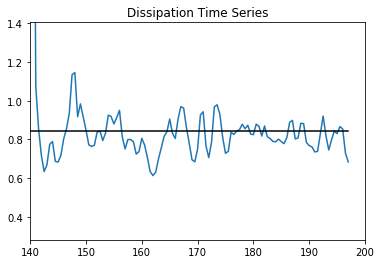

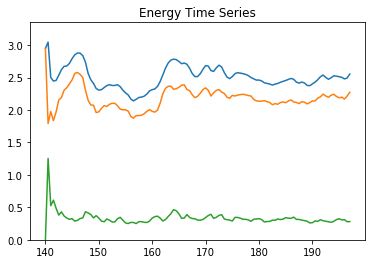

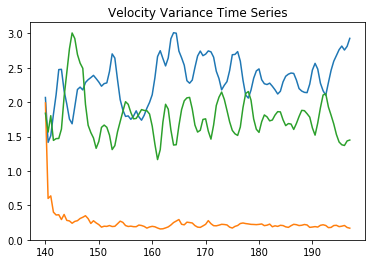

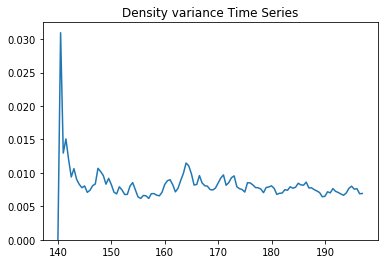

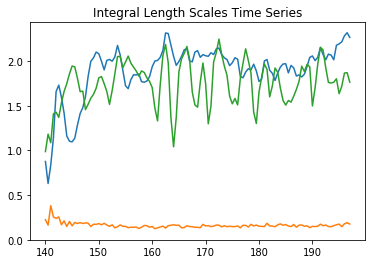

Dissipation is  0.8877818482553239
Reynolds number is  6658.271268842998 or  1938.705921935793
Froude number is  0.03437025086068367 or  0.11804082879166829
The Gibson number is  7.865510025980002 or  27.01322507360331


In [28]:
bPath = '/Users/jmelvin/Desktop/WorkFromHome/stratDNS'
bFold = 'N9-512128-Eps084-0331'
bName = 'N9-512128-Eps084'
pltPowerInput = False
processPBSim(bPath, bFold, bName, pltPowerInput, 140, 200)

viscosity is  0.00099695


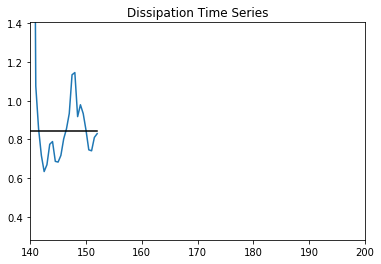

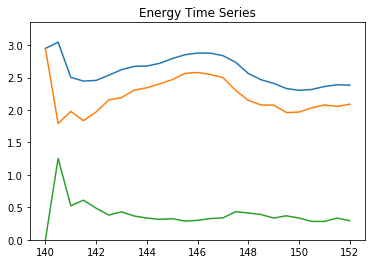

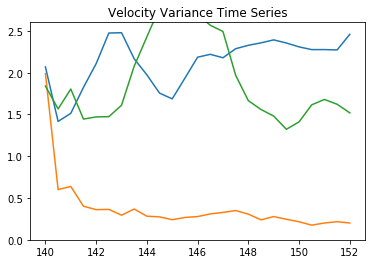

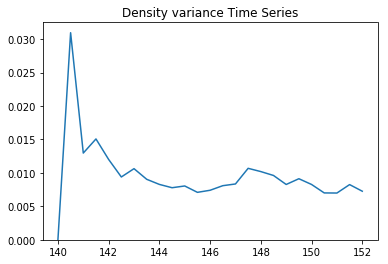

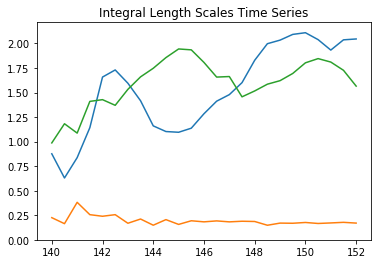

Dissipation is  1.1458797224442687
Reynolds number is  4866.994281872643 or  1785.3097000503244
Froude number is  0.046403494318667485 or  0.12650216458326433
The Gibson number is  10.480022302256568 or  28.56994986222431


In [27]:
bPath = '/Users/jmelvin/Desktop/WorkFromHome/stratDNS'
bFold = 'N9-512128-Eps084-0427'
bName = 'N9-512128-Eps084'
pltPowerInput = False
processPBSim(bPath, bFold, bName, pltPowerInput, 140, 200)

viscosity is  0.00133124


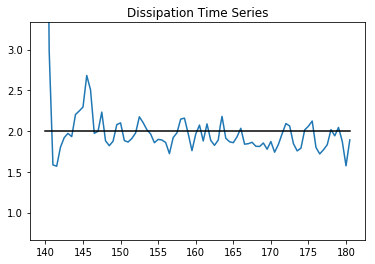

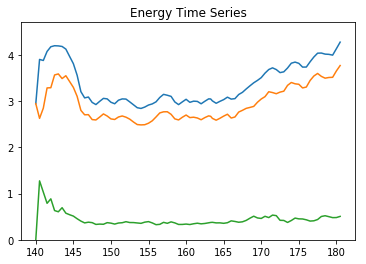

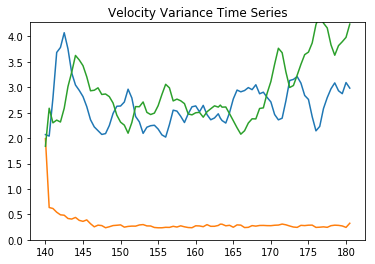

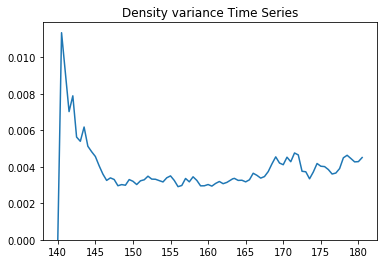

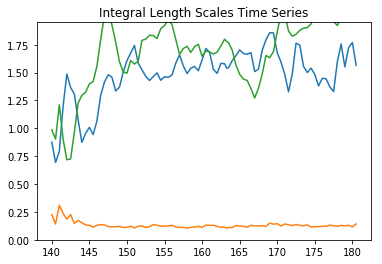

Reynolds number is  3992.3358156272775 or  1575.9940089473541
Froude number is  0.03493785480412136 or  0.0885051899079514
The Gibson number is  4.87325947825634 or  12.345026848726938


In [6]:
bPath = '/Users/jmelvin/Desktop/WorkFromHome/stratDNS'
bName = 'N15-512128-Eps200'
pltPowerInput = False
processPBSim(bPath, bName, pltPowerInput)

viscosity is  0.00133124


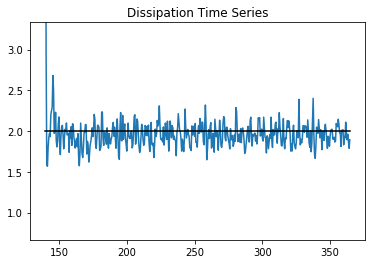

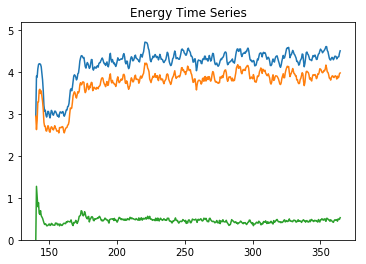

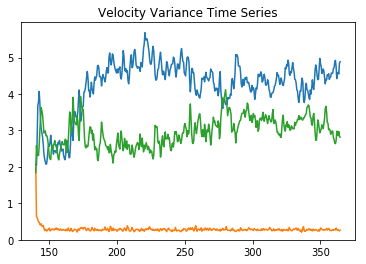

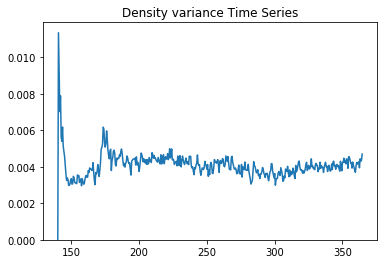

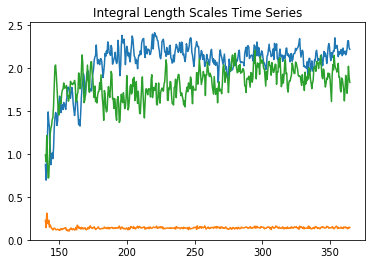

Reynolds number is  6814.7969940722105 or  1979.779172584798
Froude number is  0.026439710224592763 or  0.09101078557536825
The Gibson number is  4.763940243148313 or  16.3984378149408


In [5]:
bPath = '/Users/jmelvin/Desktop/WorkFromHome/stratDNS/secondAttempt'
bName = 'N15-512128-Eps200'
pltPowerInput = False
processPBSim(bPath, bName, pltPowerInput)

viscosity is  0.00099695


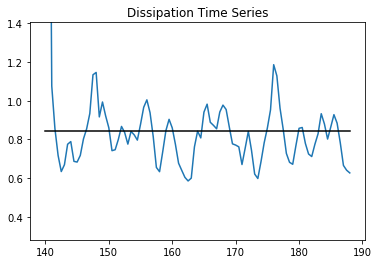

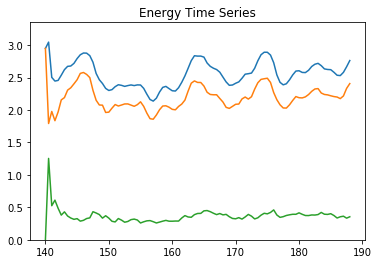

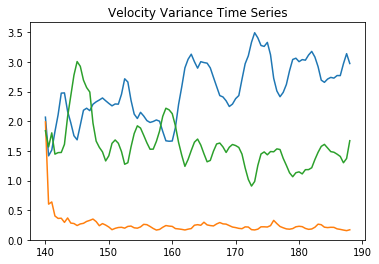

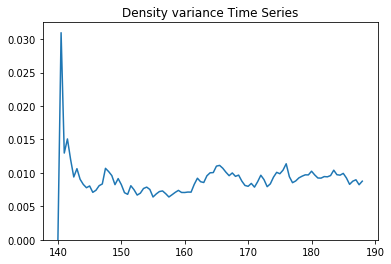

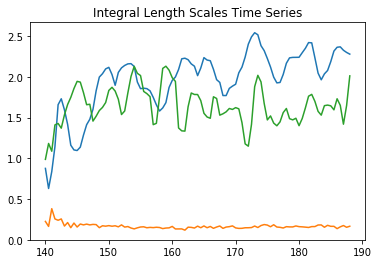

Reynolds number is  6655.6363690964645 or  1931.8394898854554
Froude number is  0.034553709652136944 or  0.11904556659704592
The Gibson number is  7.9465559500844805 or  27.377733537053928


In [7]:
bPath = '/Users/jmelvin/Desktop/WorkFromHome/stratDNS/secondAttempt'
bName = 'N9-512128-Eps084'
pltPowerInput = False
processPBSim(bPath, bName, pltPowerInput)

viscosity is  0.00099695


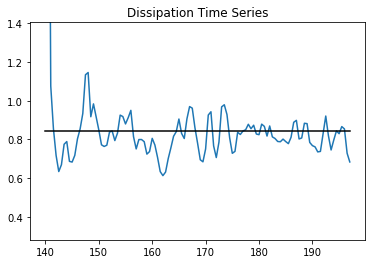

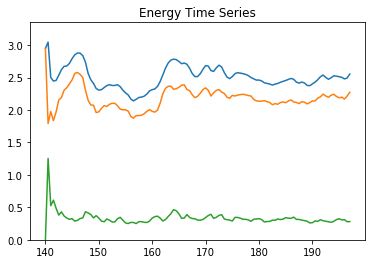

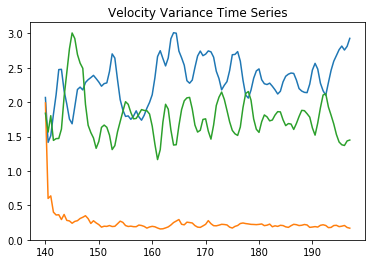

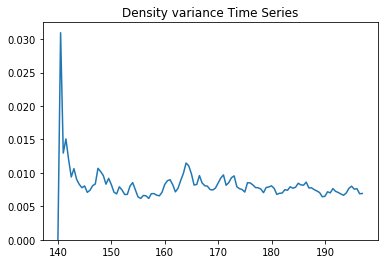

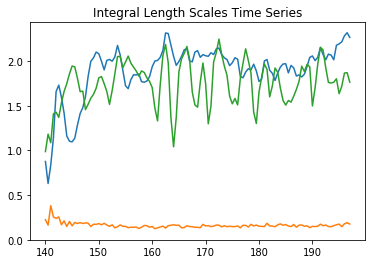

Reynolds number is  6658.271268842998 or  1938.705921935793
Froude number is  0.03437025086068367 or  0.11804082879166829
The Gibson number is  7.865510025980002 or  27.01322507360331


In [8]:
bPath = '/Users/jmelvin/Desktop/WorkFromHome/stratDNS'
bName = 'N9-512128-Eps084'
pltPowerInput = False
processPBSim(bPath, bName, pltPowerInput)

viscosity is  0.00251215


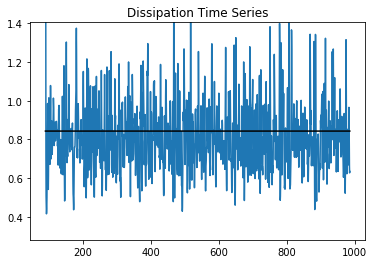

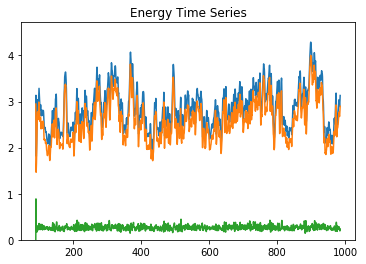

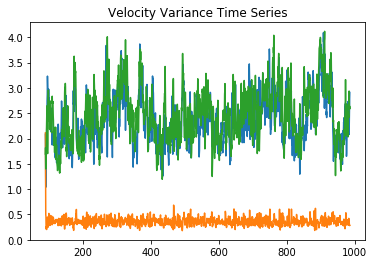

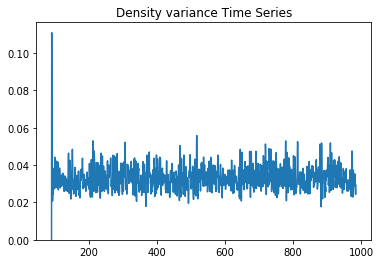

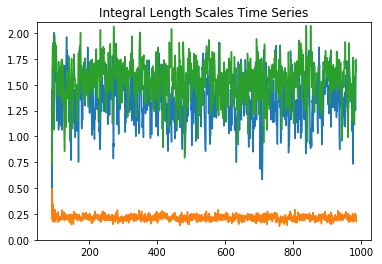

Reynolds number is  4346.5516995360895 or  746.1626121623459
Froude number is  0.05520550012974275 or  0.321583467868081
The Gibson number is  13.24675631049406 or  77.16509808480049


In [9]:
bPath = '/Users/jmelvin/Desktop/WorkFromHome/stratDNS/secondAttempt'
bName = 'N4-25664-Eps084'
pltPowerInput = False
processPBSim(bPath, bName, pltPowerInput)

viscosity is  0.0033545


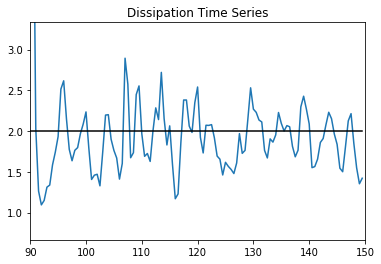

In [19]:
bPath = '/Users/jmelvin/Desktop/WorkFromHome/stratDNS'
bName = 'N4-25664-Eps200'
pltPowerInput = False
processPBSim(bPath, bName, pltPowerInput,90,150)

viscosity is  0.0033545
Moving average of  500  pts out of  1151


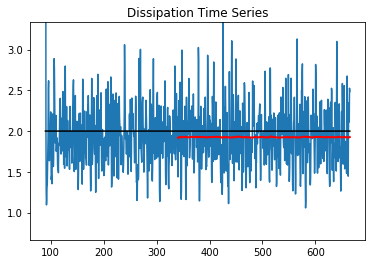

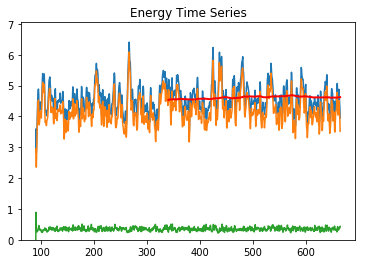

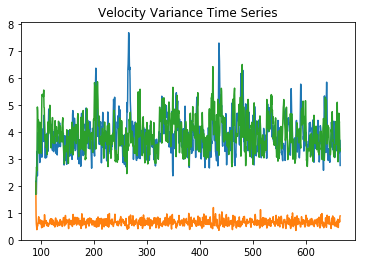

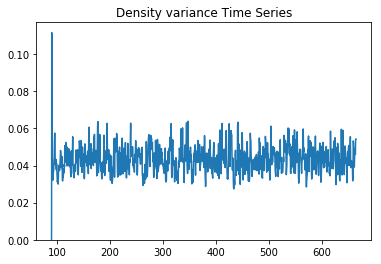

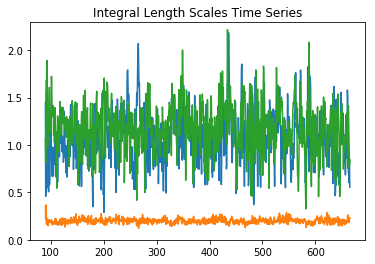

Dissipation is  1.9298339748275977
Reynolds number is  3340.900697886884 or  625.9344489385659
Froude number is  0.08697699896477519 or  0.4642363382208481
The Gibson number is  25.273908263414963 or  134.89849919389803


In [72]:
bPath = '/Users/jmelvin/Desktop/WorkFromHome/stratDNS/secondAttempt'
bName = 'N4-25664-Eps200'
pltPowerInput = False
processPBSim(bPath, bName, bName, pltPowerInput, wind=500)

viscosity is  0.00099695


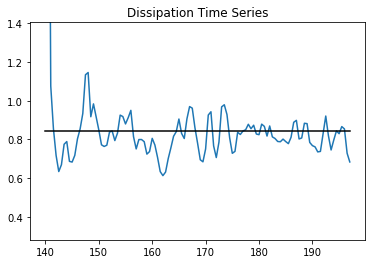

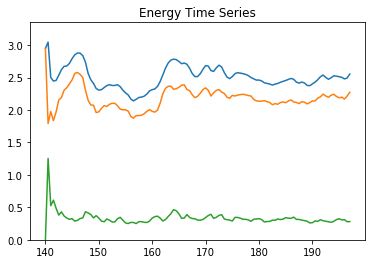

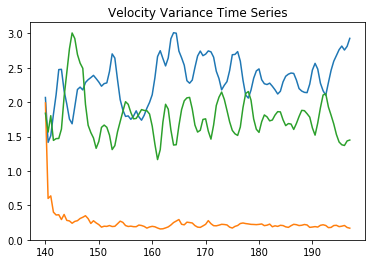

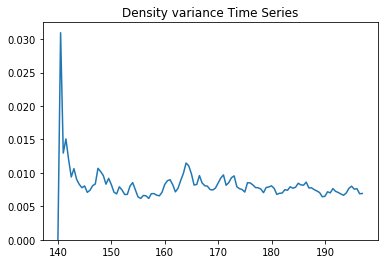

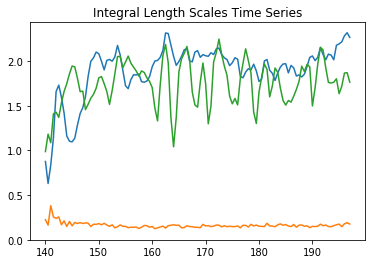

Reynolds number is  6658.271268842998 or  1938.705921935793
Froude number is  0.03437025086068367 or  0.11804082879166829
The Gibson number is  7.865510025980002 or  27.01322507360331


In [17]:
bPath = '/Users/jmelvin/Desktop/WorkFromHome/stratDNS'
bFold = 'N9-512128-Eps084-0331'
bName = 'N9-512128-Eps084'
pltPowerInput = False
processPBSim(bPath, bFold, bName, pltPowerInput)

viscosity is  0.00099695
Moving average of  100  pts out of  387


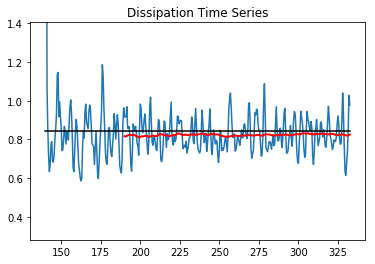

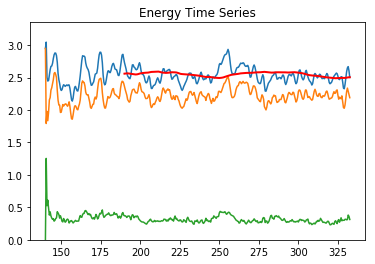

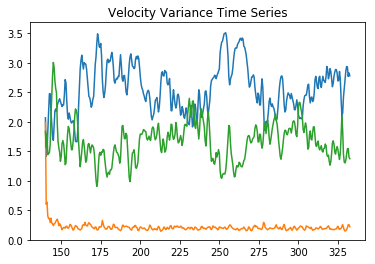

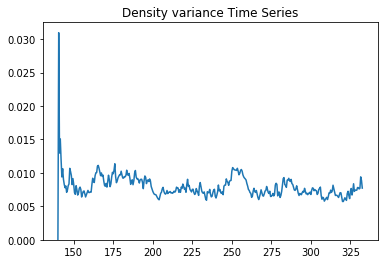

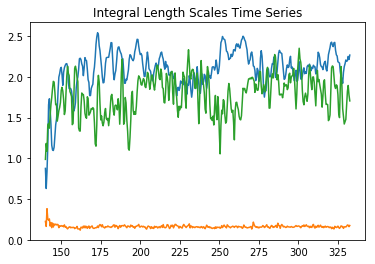

Dissipation is  0.84287405987251
Reynolds number is  7452.797381121433 or  2027.9171992157674
Froude number is  0.03162626240056144 or  0.116229659517023
The Gibson number is  7.45444052491693 or  27.39581026449752


In [70]:
bPath = '/Users/jmelvin/Desktop/WorkFromHome/stratDNS'
bFold = 'N9-512128-Eps084-0412'
bName = 'N9-512128-Eps084'
pltPowerInput = False
processPBSim(bPath, bFold, bName, pltPowerInput,wind=100)

viscosity is  0.00099695
Moving average of  100  pts out of  554


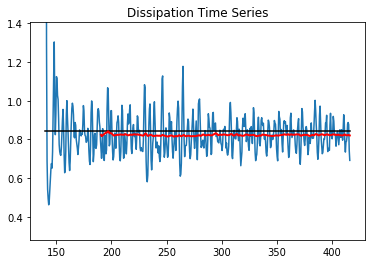

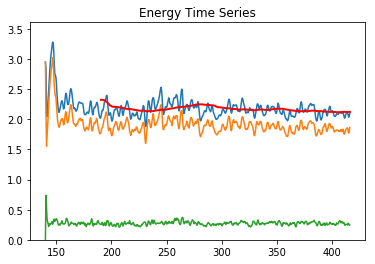

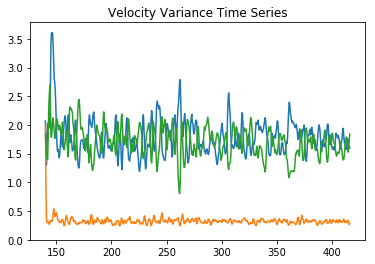

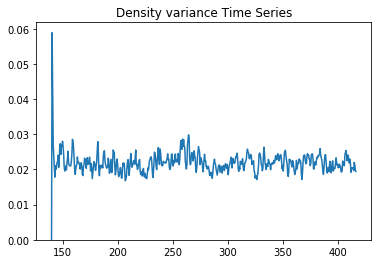

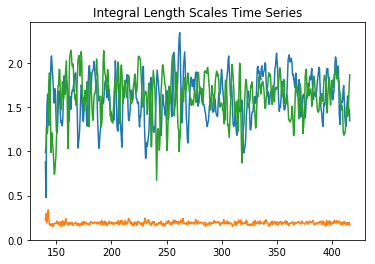

Dissipation is  0.8370026446398446
Reynolds number is  5409.717467679786 or  1689.2323115295808
Froude number is  0.06500911583689793 or  0.20818980734677173
The Gibson number is  22.862467583759305 or  73.21638912420232


In [69]:
bPath = '/Users/jmelvin/Desktop/WorkFromHome/stratDNS'
bFold = 'N5-512128-Eps084-0413'
bName = 'N5-512128-Eps084'
pltPowerInput = False
processPBSim(bPath, bFold, bName, pltPowerInput,wind=100)

viscosity is  0.00133124
Moving average of  100  pts out of  450


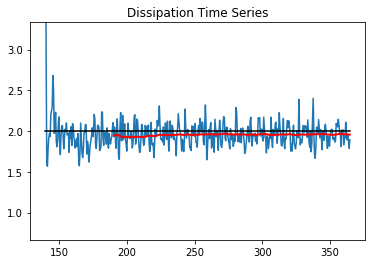

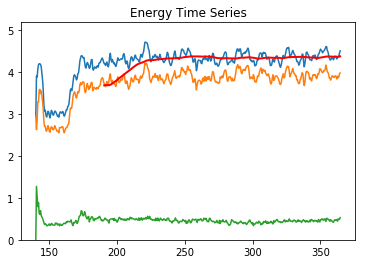

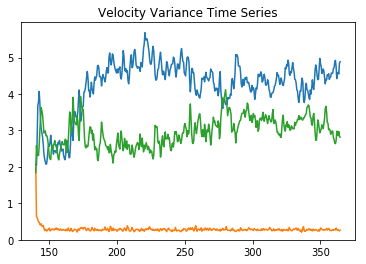

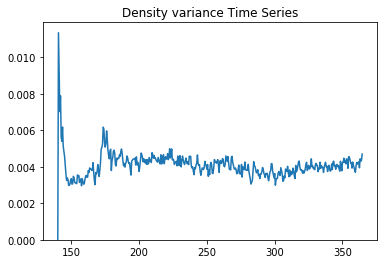

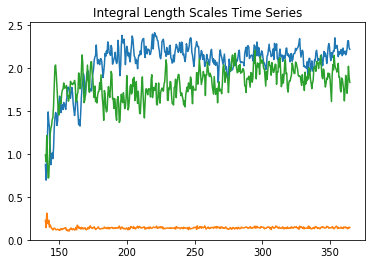

Dissipation is  1.9693688331980046
Reynolds number is  6814.7969940722105 or  1979.779172584798
Froude number is  0.026439710224592763 or  0.09101078557536825
The Gibson number is  4.763940243148313 or  16.3984378149408


In [68]:
bPath = '/Users/jmelvin/Desktop/WorkFromHome/stratDNS'
bFold = 'N15-512128-Eps200-0413'
bName = 'N15-512128-Eps200'
pltPowerInput = False
processPBSim(bPath, bFold, bName, pltPowerInput, wind=100)

viscosity is  0.041


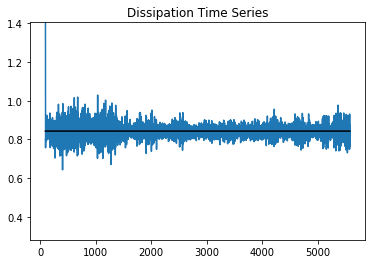

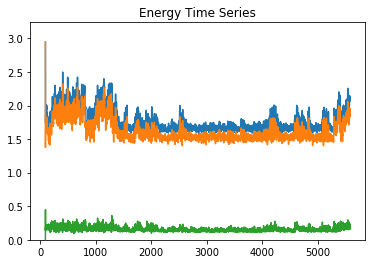

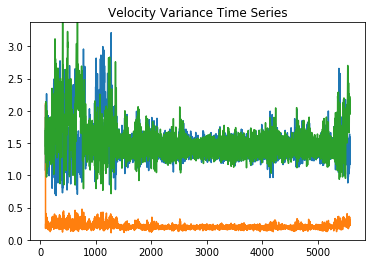

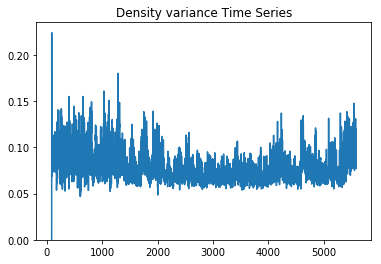

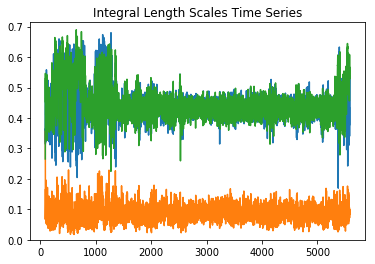

Dissipation is  0.8414474186207327
Reynolds number is  82.98207898602332 or  20.062582762451317
Froude number is  0.22330466377684058 or  0.9236241149448631
The Gibson number is  4.137899116876837 or  17.11501831137695


In [37]:
bPath = '/Users/jmelvin/Desktop/WorkFromHome/stratDNS'
bFold = 'N2-3232-Eps084-new'
bName = 'N2-323232-Eps084'
pltPowerInput = False
processPBSim(bPath, bFold, bName, pltPowerInput)

viscosity is  0.054


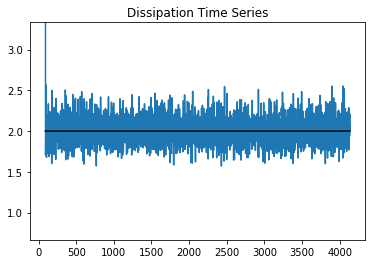

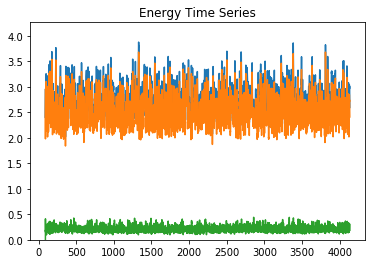

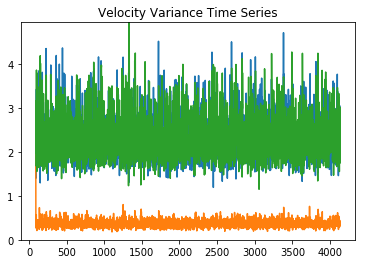

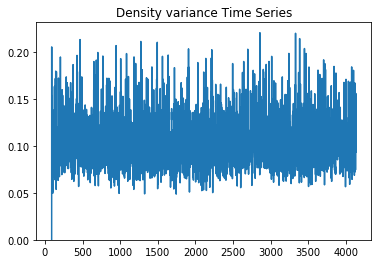

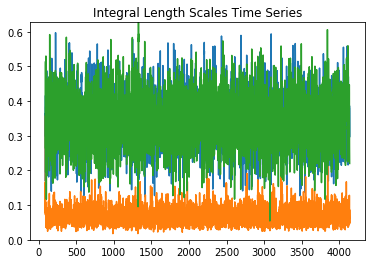

Dissipation is  1.9962324239846254
Reynolds number is  59.641188660005575 or  16.724125404872336
Froude number is  0.365833045646325 or  1.3046253340757854
The Gibson number is  7.982007945894699 or  28.465251859931463


In [38]:
bPath = '/Users/jmelvin/Desktop/WorkFromHome/stratDNS'
bFold = 'N2-3232-Eps200-new'
bName = 'N2-323232-Eps200'
pltPowerInput = False
processPBSim(bPath, bFold, bName, pltPowerInput)

viscosity is  0.016
Moving average of  500  pts out of  1229


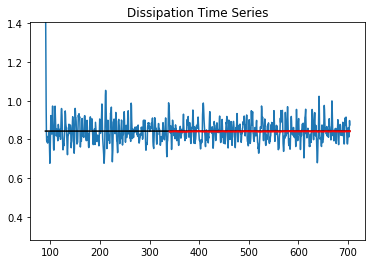

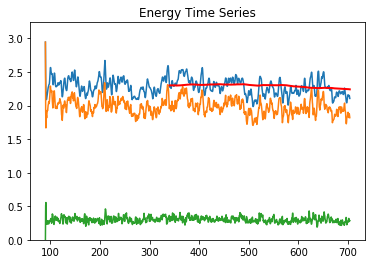

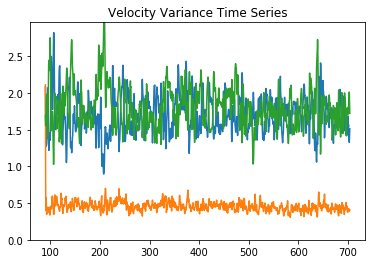

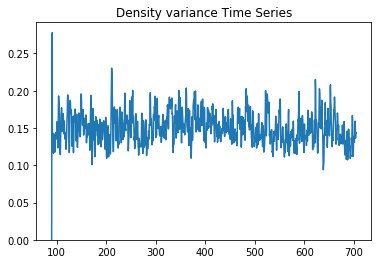

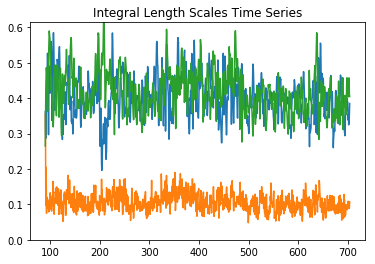

Dissipation is  0.8435418163006109
Reynolds number is  314.5687639370996 or  53.09461940180521
Froude number is  0.17440674160034958 or  1.0333045748446172
The Gibson number is  9.56846191327365 or  56.69009912396829


In [57]:
bPath = '/Users/jmelvin/Desktop/WorkFromHome/stratDNS'
bFold = 'N2-6464-Eps084-new'
bName = 'N2-646464-Eps084'
pltPowerInput = False
processPBSim(bPath, bFold, bName, pltPowerInput, wind=500)

viscosity is  0.0033545
Moving average of  600  pts out of  1151


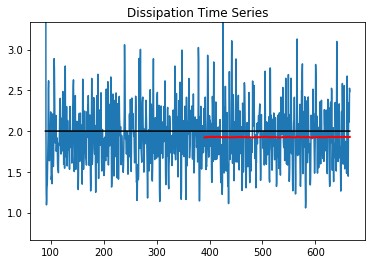

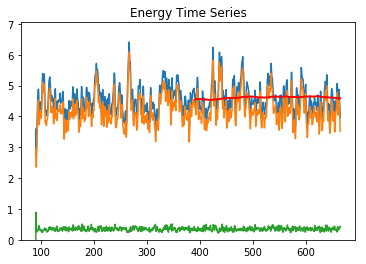

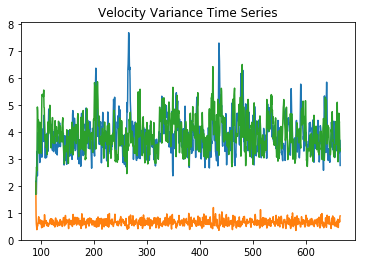

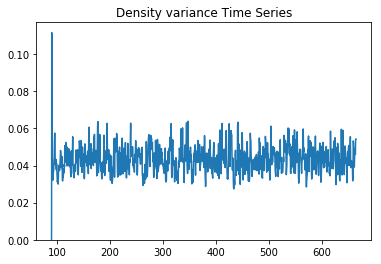

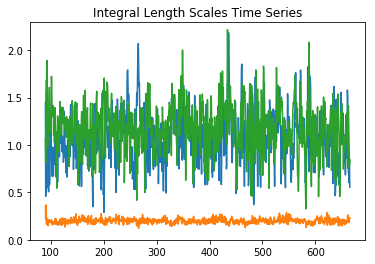

Dissipation is  1.9298339748275977
Reynolds number is  3340.900697886884 or  625.9344489385659
Froude number is  0.08697699896477519 or  0.4642363382208481
The Gibson number is  25.273908263414963 or  134.89849919389803


In [60]:
bPath = '/Users/jmelvin/Desktop/WorkFromHome/stratDNS'
bFold = 'N4-25664-Eps200-new'
bName = 'N4-25664-Eps200'
pltPowerInput = False
processPBSim(bPath, bFold, bName, pltPowerInput, wind=600)

viscosity is  0.0085
Moving average of  500  pts out of  1431


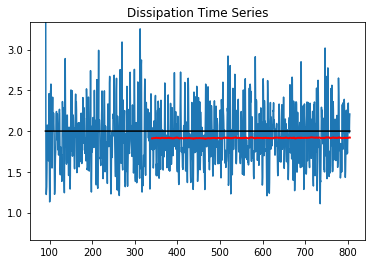

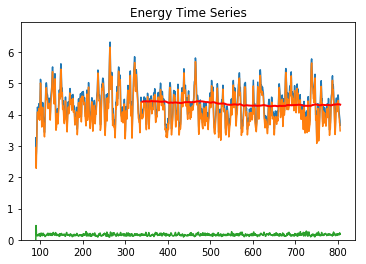

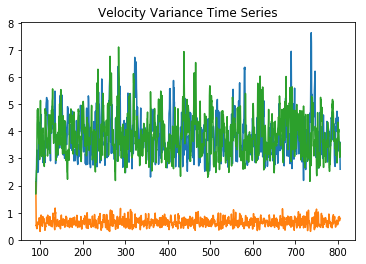

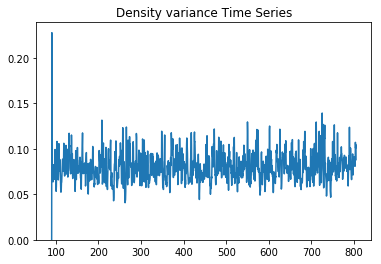

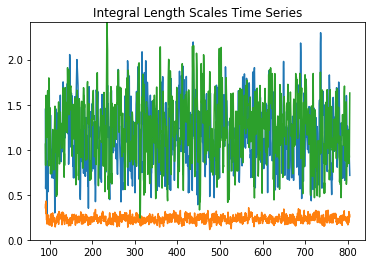

Dissipation is  1.9210815693470724
Reynolds number is  1078.1117118480825 or  253.6729483196166
Froude number is  0.21048476945588934 or  0.8945616654012358
The Gibson number is  47.76448681402445 or  202.9993855700021


In [73]:
bPath = '/Users/jmelvin/Desktop/WorkFromHome/stratDNS'
bFold = 'N2-12832-Eps200'
bName = 'N2-12832-Eps200'
pltPowerInput = False
processPBSim(bPath, bFold, bName, pltPowerInput,wind=500)

viscosity is  0.0065
Moving average of  50  pts out of  1793
         step        time    keDiss    peDiss  totalDiss  targetDiss   rollAvg
0      568883   90.000101  6.654056  0.000000   6.654056    0.842863       NaN
1      569223   90.501389  3.827092  0.671772   4.498864    0.842863       NaN
2      569415   91.000249  1.169221  0.575189   1.744410    0.842863       NaN
3      569572   91.500733  0.530675  0.262197   0.792873    0.842863       NaN
4      569735   92.000446  0.325624  0.160786   0.486411    0.842863       NaN
...       ...         ...       ...       ...        ...         ...       ...
1788  1067570  984.001482  0.698712  0.213236   0.911948    0.842863  0.794776
1789  1067869  984.500460  0.778865  0.201501   0.980365    0.842863  0.800783
1790  1068151  985.001328  0.803955  0.219718   1.023674    0.842863  0.808130
1791  1068433  985.500884  0.702362  0.208590   0.910952    0.842863  0.811195
1792  1068707  986.000702  0.664441  0.188051   0.852492    0.842863  

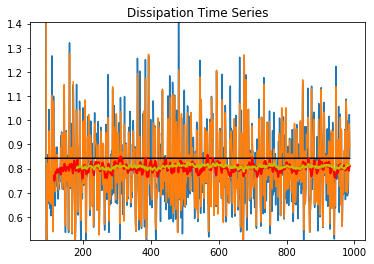

         step        time        ke        pe       tke   rollAvg
0      568883   90.000101  2.946349  0.000000  2.946349       NaN
1      569223   90.501389  2.417131  0.469252  2.886383       NaN
2      569415   91.000249  1.415044  0.416872  1.831916       NaN
3      569572   91.500733  1.511690  0.142930  1.654620       NaN
4      569735   92.000446  1.597962  0.161182  1.759144       NaN
...       ...         ...       ...       ...       ...       ...
1788  1067570  984.001482  3.034093  0.166358  3.200451  3.396704
1789  1067869  984.500460  2.958637  0.165553  3.124190  3.399525
1790  1068151  985.001328  2.857422  0.164004  3.021426  3.398799
1791  1068433  985.500884  2.787809  0.143998  2.931807  3.395188
1792  1068707  986.000702  2.760001  0.142333  2.902334  3.391169

[1793 rows x 6 columns]


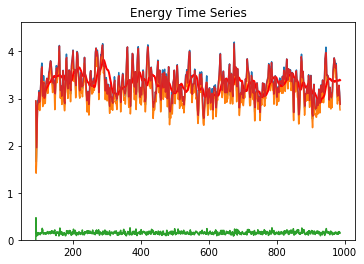

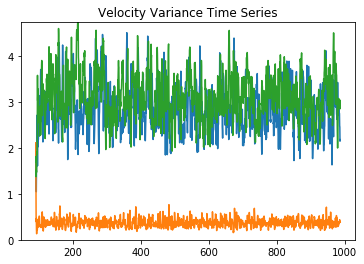

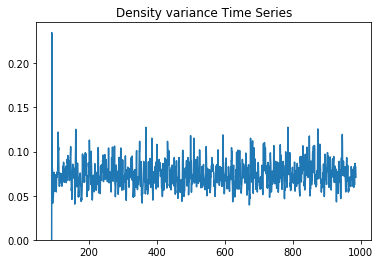

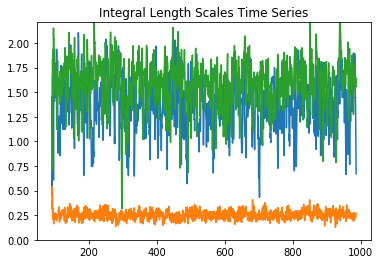

Dissipation is  0.8076310308804225
Reynolds number is  2197.85662644717 or  324.99430208584
Froude number is  0.10428745368950641 or  0.7052704298989331
The Gibson number is  23.90360953494429 or  161.65423909034158


In [56]:
bPath = '/Users/blmindell/Desktop/Jeremy/WorkFromHome/stratDNS'
bFold = 'N2-12832-Eps084-0330'
bName = 'N2-12832-Eps084'
pltPowerInput = False
#processPBSim(bPath, bFold, bName, pltPowerInput, wind=50)

%store -r sData

processPBSim(bPath, bFold, bName, pltPowerInput, sData, wind=50)

viscosity is  0.0065
Moving average of  50  pts out of  119
       step        time    keDiss    peDiss  totalDiss  targetDiss   rollAvg
0    568883   90.000101  1.290251  0.000000   1.290251    0.842863       NaN
1    569113   90.500489  0.955288  0.328958   1.284245    0.842863       NaN
2    569312   91.000442  0.774061  0.478030   1.252091    0.842863       NaN
3    569510   91.500229  0.734737  0.347633   1.082370    0.842863       NaN
4    569707   92.000496  0.620871  0.275899   0.896770    0.842863       NaN
..      ...         ...       ...       ...        ...         ...       ...
114  595328  147.000574  0.581393  0.257884   0.839278    0.842863  0.853759
115  595561  147.500493  0.515095  0.219485   0.734580    0.842863  0.847690
116  595818  148.000761  0.488682  0.190491   0.679173    0.842863  0.841507
117  596063  148.500381  0.506853  0.197645   0.704497    0.842863  0.837147
118  596343  149.000495  0.521975  0.231279   0.753255    0.842863  0.834705

[119 rows x 7 c

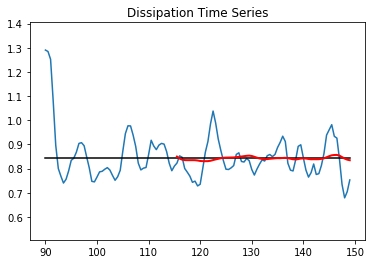

       step        time        ke        pe       tke   rollAvg
0    568883   90.000101  2.945238  0.000000  2.945238       NaN
1    569113   90.500489  2.186133  0.552954  2.739087       NaN
2    569312   91.000442  1.889127  0.625758  2.514885       NaN
3    569510   91.500229  2.011886  0.336807  2.348693       NaN
4    569707   92.000496  1.976798  0.297860  2.274658       NaN
..      ...         ...       ...       ...       ...       ...
114  595328  147.000574  1.946317  0.310931  2.257248  2.436778
115  595561  147.500493  2.012381  0.274302  2.286683  2.431761
116  595818  148.000761  2.108097  0.245919  2.354016  2.429891
117  596063  148.500381  2.180902  0.252674  2.433577  2.430801
118  596343  149.000495  2.212852  0.276681  2.489534  2.433338

[119 rows x 6 columns]


TypeError: list indices must be integers or slices, not tuple

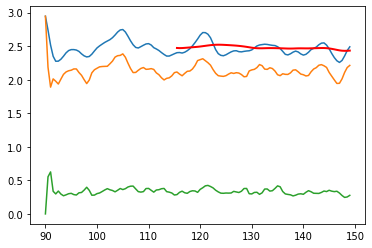

In [54]:
bPath = '/Users/blmindell/Desktop/Jeremy/WorkFromHome/stratDNS'
bFold = 'N2-128128-Eps084'
bName = 'N2-128128-Eps084'
pltPowerInput = False

sData = []

processPBSim(bPath, bFold, bName, pltPowerInput, sData, wind=50)

viscosity is  0.0065
Moving average of  100  pts out of  1831


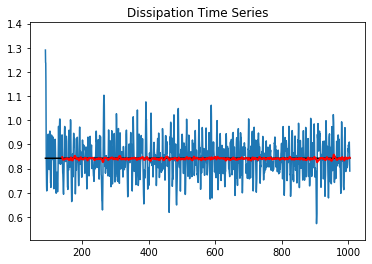

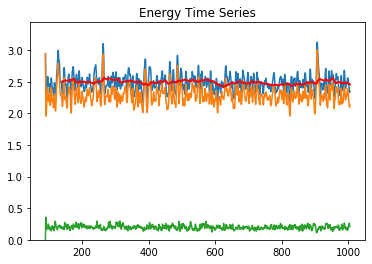

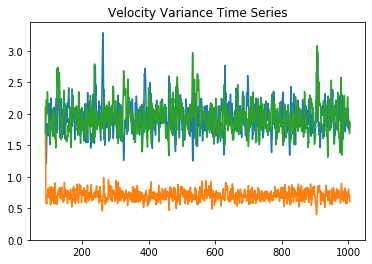

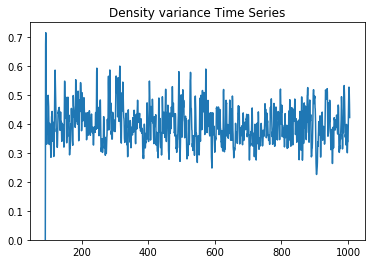

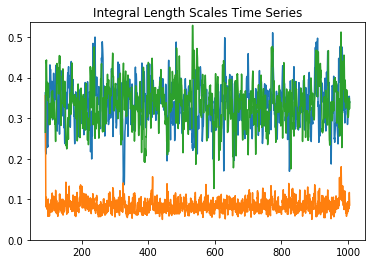

Dissipation is  0.841645762605264
Reynolds number is  865.7669186211475 or  124.43486113329446
Froude number is  0.34519050617772196 or  2.4016944942030993
The Gibson number is  103.1617433328784 or  717.7572573430108


In [16]:
bPath = '/Users/blmindell/Desktop/Jeremy/WorkFromHome/stratDNS'
bFold = 'N1-128128-Eps084'
bName = 'N1-128128-Eps084'
pltPowerInput = False

sData = []

processPBSim(bPath, bName, bName, pltPowerInput, sData, wind=100)

viscosity is  0.0065
Moving average of  100  pts out of  1776


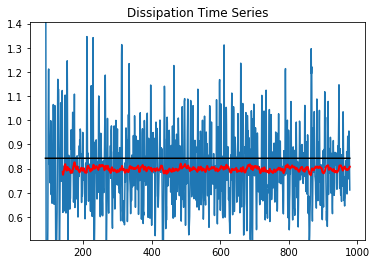

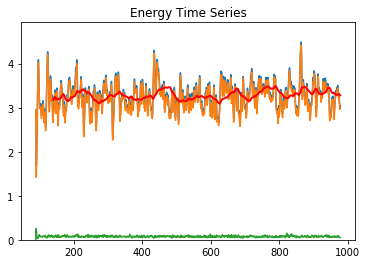

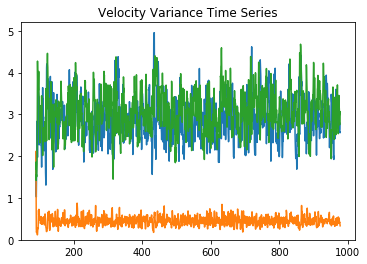

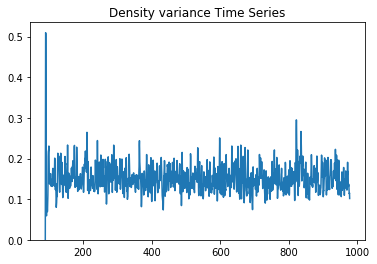

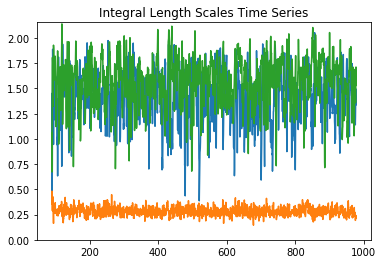

Dissipation is  0.8029937812815828
Reynolds number is  1921.689263992797 or  324.5967159025204
Froude number is  0.23838248852101224 or  1.4112806645039702
The Gibson number is  109.20231927207149 or  646.5035358252806


In [14]:
bPath = '/Users/blmindell/Desktop/Jeremy/WorkFromHome/stratDNS'
bFold = 'N1-12832-Eps084'
bName = 'N1-12832-Eps084'
pltPowerInput = False

sData = []

processPBSim(bPath, bName, bName, pltPowerInput, sData, wind=100)